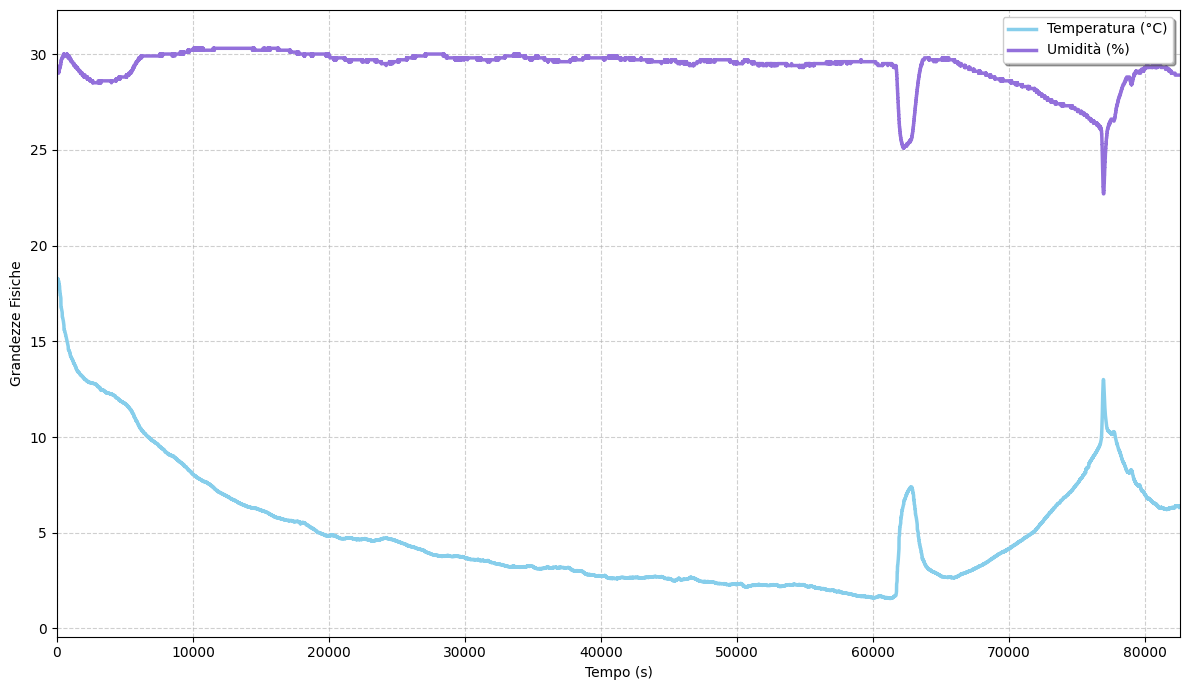

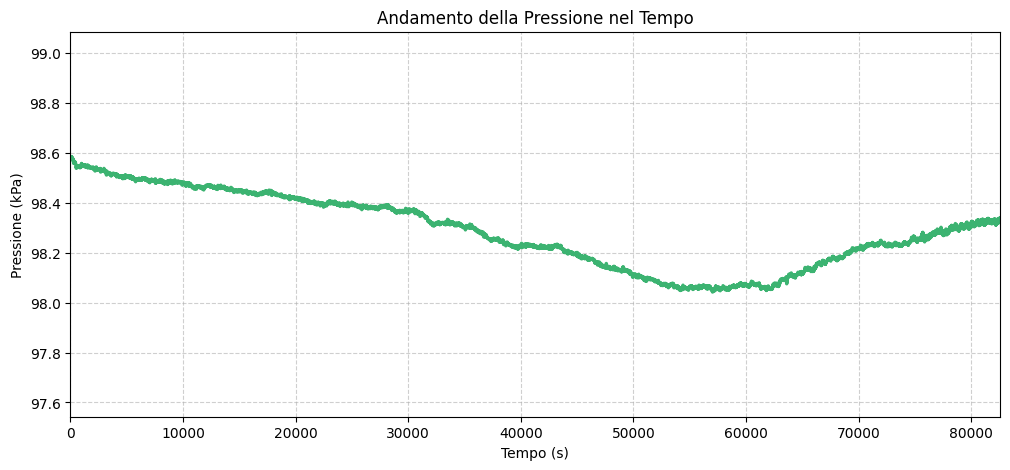

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os

# --- Configurazione ---
NOME_FILE_LOG = '24h-1L-10g.csv'
STEP_TEMPORALE_S = 3 #secondi



# Leggiamo il CSV saltando l'header testuale
df = pd.read_csv(NOME_FILE_LOG, skiprows=1, header=None, skipinitialspace=True)

# 2. Parsing e Pulizia
df.columns = ['Timestamp_Raw', 'Temp_K', 'Hum_Pct', 'Pres_kPa']
# Estrazione valori numerici tramite Regex e conversione
df['Temperatura'] = df['Temp_K'].astype(str).str.extract(r'(\d+\.\d+)').astype(float) - 273.15
df['Umidita'] = df['Hum_Pct'].astype(str).str.extract(r'(\d+\.\d+)').astype(float)
df['Pressione'] = df['Pres_kPa'].astype(str).str.extract(r'(\d+\.\d+)').astype(float)

# Rimozione righe non valide
df.dropna(subset=['Temperatura', 'Umidita', 'Pressione'], inplace=True)

# 3. Creazione Asse Temporale Sintetico
# Crea un array [0, 3, 6, 9, ...] basato sul numero di campioni
df['Tempo_Simulato_s'] = np.arange(len(df)) * STEP_TEMPORALE_S
# 4. Scaling Pressione (per coerenza visiva)
df['Pressione_Scalata'] = df['Pressione'] / 4.0
# 5. Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))
# Tracciamento delle curve
ax1.plot(df['Tempo_Simulato_s'], df['Temperatura'], 
         label='Temperatura (°C)', color='skyblue', linewidth=2.5)
ax1.plot(df['Tempo_Simulato_s'], df['Umidita'], 
         label='Umidità (%)', color='mediumpurple', linewidth=2.5)
# Configurazione Assi e Titoli
ax1.set_xlim(left=0, right=df['Tempo_Simulato_s'].max() + STEP_TEMPORALE_S)

# Impostazione limiti Y dinamici con buffer
vals = df[['Temperatura', 'Umidita']].values
y_min, y_max = np.nanmin(vals), np.nanmax(vals)
ax1.set_ylim(bottom=y_min - 2, top=y_max + 2)
ax1.set_xlabel(f'Tempo (s)')
ax1.set_ylabel('Grandezze Fisiche')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()

# faccio un plot solo pressione nel tempo
plt.figure(figsize=(12, 5))
plt.plot(df['Tempo_Simulato_s'], df['Pressione'], 
         label='Pressione (kPa)', color='mediumseagreen', linewidth=2.5)
plt.xlim(left=0, right=df['Tempo_Simulato_s'].max() + STEP_TEMPORALE_S)
plt.ylim(bottom=df['Pressione'].min() - 0.5, top=df['Pressione'].max() + 0.5)
plt.xlabel(f'Tempo (s)')
plt.ylabel('Pressione (kPa)')
plt.title('Andamento della Pressione nel Tempo')
plt.grid(True, linestyle='--', alpha=0.6)


In [60]:

# --- CONFIGURAZIONE INCERTEZZE ---
u_P_kpa = 0.1     # kPa
u_T_c = 1.0       # °C
u_UR_pct = 4.0    # %
u_V_ml = 3.0      # ml

volume_ml = 1015.0 # Volume nominale tolto elettronica 

# --- PREPARAZIONE DATI (SI) ---

p_tot_pa = df['Pressione'] * 1000.0       # kPa -> Pa
t_c_series = df['Temperatura'] 
ur_pct_series = df['Umidita']

# --- DEFINIZIONE LOGICA FISICA (Helper Vettoriale) ---
def core_physics_vectorized(p_pa, t_c, ur_pct, v_ml):
    # 1. Costanti
    Rd = 287.058    # J/kgK (Aria secca)
    Rv = 461.495    # J/kgK (Vapore)
    Md = 0.028964   # kg/mol (Aria secca)
    Mv = 0.018015   # kg/mol (Acqua)
    
    # 2. Variabili derivate locali
    tk = t_c + 273.15       # Ricalcolato qui per seguire le perturbazioni di T
    v_m3 = v_ml * 1e-6 
    
    # 3. Pressioni (Magnus-Tetens)
    # Es: Pressione vapore saturo
    es_hpa = 6.112 * np.exp((17.67 * t_c) / (t_c + 243.5))
    es_pa = es_hpa * 100.0
    
    # Pressione parziale vapore e aria secca
    p_vap = es_pa * (ur_pct / 100.0)
    p_dry = p_pa - p_vap
    
    # 4. Densità (rho = P / R*T)
    rho_d = p_dry / (Rd * tk)
    rho_v = p_vap / (Rv * tk)
    densita_tot = rho_d + rho_v
    
    # 5. Moli (n = rho * V / MM)
    n_d = (rho_d * v_m3) / Md
    n_v = (rho_v * v_m3) / Mv
    n_tot = n_d + n_v
    
    return n_tot, densita_tot

# --- 1. CALCOLO NOMINALE ---
n_nominale, rho_nominale = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series, volume_ml)

# --- 2. PROPAGAZIONE ERRORI (Metodo Numerico) ---

# A. Perturbazione Pressione (Attenzione: u_P in kPa -> convertire in Pa)
n_p, rho_p = core_physics_vectorized(p_tot_pa + (u_P_kpa * 1000.0), t_c_series, ur_pct_series, volume_ml)
dn_dP = n_p - n_nominale
drho_dP = rho_p - rho_nominale

# B. Perturbazione Temperatura
n_t, rho_t = core_physics_vectorized(p_tot_pa, t_c_series + u_T_c, ur_pct_series, volume_ml)
dn_dT = n_t - n_nominale
drho_dT = rho_t - rho_nominale

# C. Perturbazione Umidità
n_ur, rho_ur = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series + u_UR_pct, volume_ml)
dn_dUR = n_ur - n_nominale
drho_dUR = rho_ur - rho_nominale

# D. Perturbazione Volume
n_v, rho_v = core_physics_vectorized(p_tot_pa, t_c_series, ur_pct_series, volume_ml + u_V_ml)
dn_dV = n_v - n_nominale
drho_dV = rho_v - rho_nominale

# --- 3. COMBINAZIONE RSS (Root Sum Square) ---
u_n_tot = np.sqrt(dn_dP**2 + dn_dT**2 + dn_dUR**2 + dn_dV**2)
u_rho_tot = np.sqrt(drho_dP**2 + drho_dT**2 + drho_dUR**2 + drho_dV**2)

# --- 4. SALVATAGGIO RISULTATI ---
# Aggiungiamo direttamente le colonne al dataframe esistente o ne creiamo uno nuovo
df_risultati = pd.DataFrame({
    'Moli': n_nominale,
    'Err_Moli': u_n_tot,
    'Densita': rho_nominale,
    'Err_Densita': u_rho_tot
})

# Visualizza prime righe
print(df_risultati)

           Moli  Err_Moli   Densita  Err_Densita
0      0.041298  0.000191  1.175681     0.004383
1      0.041299  0.000191  1.175729     0.004383
2      0.041299  0.000191  1.175729     0.004383
3      0.041299  0.000191  1.175729     0.004383
4      0.041299  0.000191  1.175729     0.004383
...         ...       ...       ...          ...
27520  0.042944  0.000204  1.224127     0.004631
27521  0.042944  0.000204  1.224147     0.004631
27522  0.042944  0.000204  1.224147     0.004631
27523  0.042946  0.000204  1.224209     0.004631
27524  0.042952  0.000204  1.224365     0.004632

[27525 rows x 4 columns]


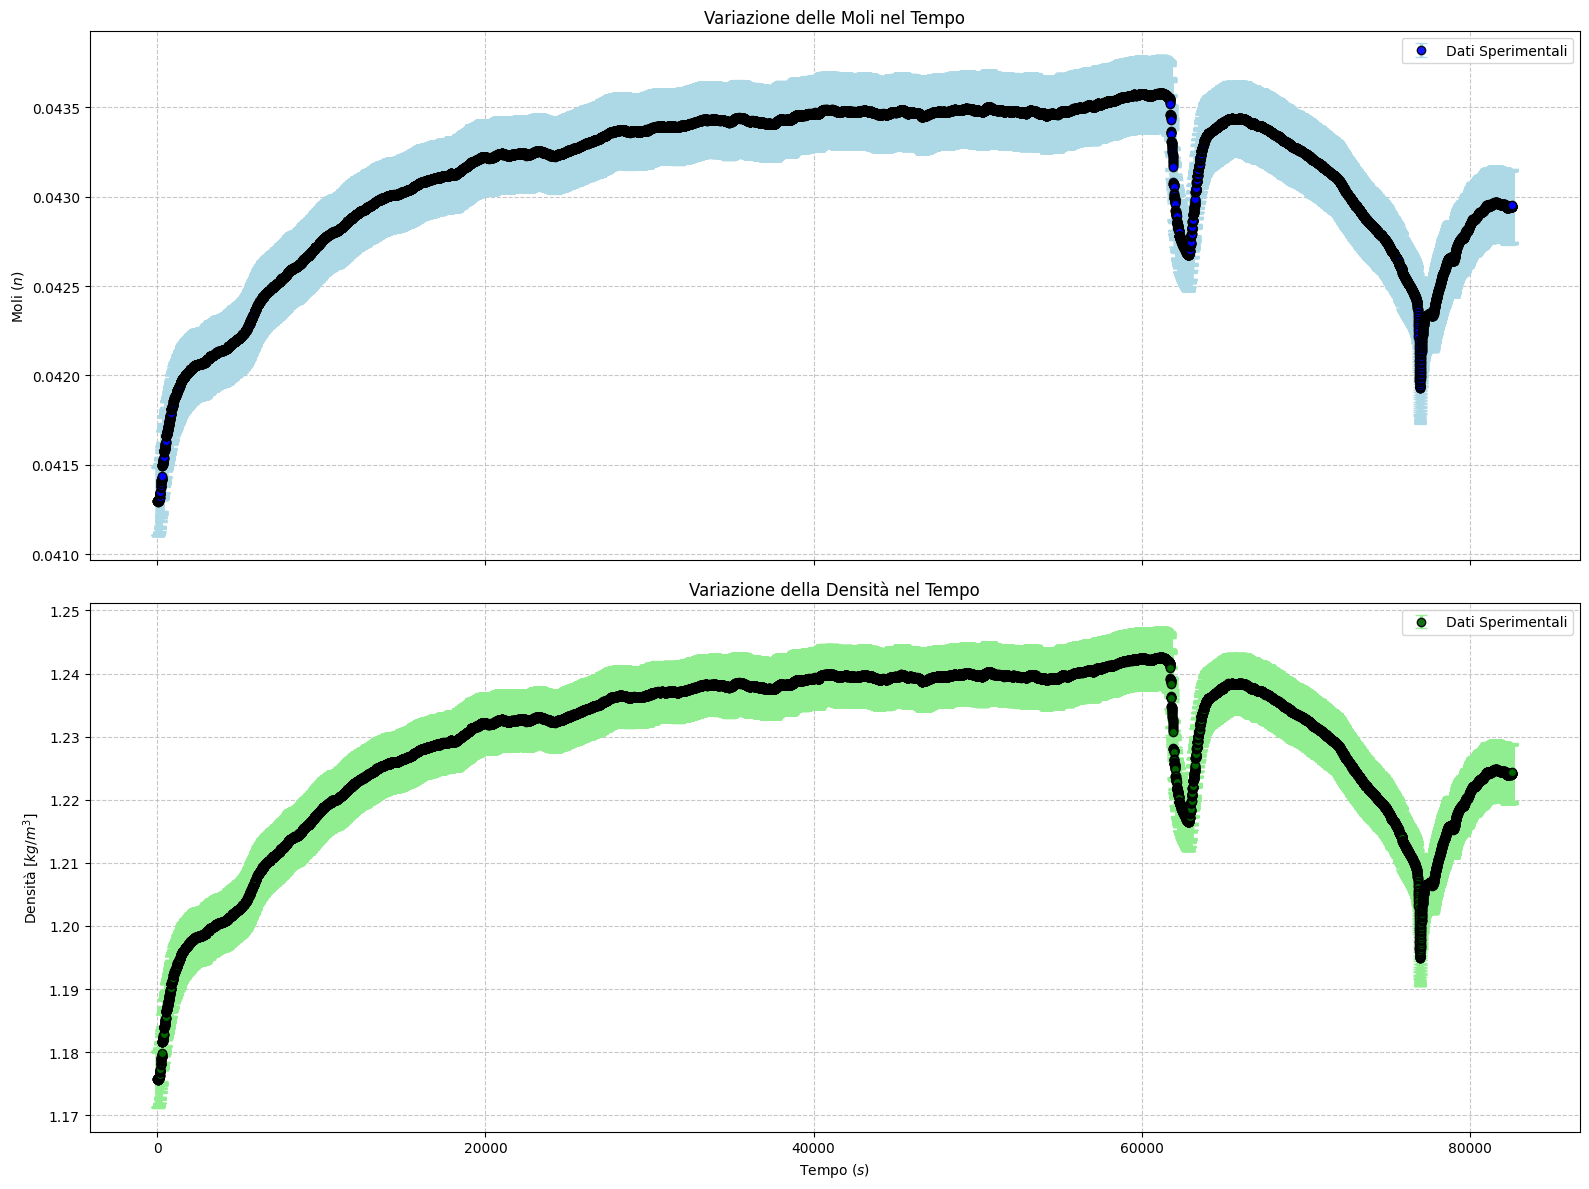

In [61]:
#faccio ora unisogramma delle moli e uno della densità

# Configurazione layout: 2 righe, 1 colonna, dimensioni aumentate (larghezza e altezza)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Asse temporale
t = df_risultati.index * 3

# --- Grafico 1: Moli ---
# ecolor: colore barra errore (più chiaro), color: colore punto (più scuro)
ax1.errorbar(t, df_risultati['Moli'], 
             yerr=df_risultati['Err_Moli'], 
             fmt='o', markersize=6, markerfacecolor='blue', markeredgecolor='black', # Stile Punto
             ecolor='lightblue', elinewidth=2.5, capsize=4, alpha=0.9,               # Stile Errore
             label='Dati Sperimentali')

ax1.set_ylabel(r'Moli ($n$)')
ax1.set_title(r'Variazione delle Moli nel Tempo')
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend(loc='upper right')

# --- Grafico 2: Densità ---
ax2.errorbar(t, df_risultati['Densita'], 
             yerr=df_risultati['Err_Densita'], 
             fmt='o', markersize=6, markerfacecolor='darkgreen', markeredgecolor='black',
             ecolor='lightgreen', elinewidth=2.5, capsize=4, alpha=0.9,
             label='Dati Sperimentali')

ax2.set_xlabel(r'Tempo ($s$)')
ax2.set_ylabel(r'Densità [$kg/m^3$]')
ax2.set_title(r'Variazione della Densità nel Tempo')
ax2.grid(True, which='both', linestyle='--', alpha=0.7)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

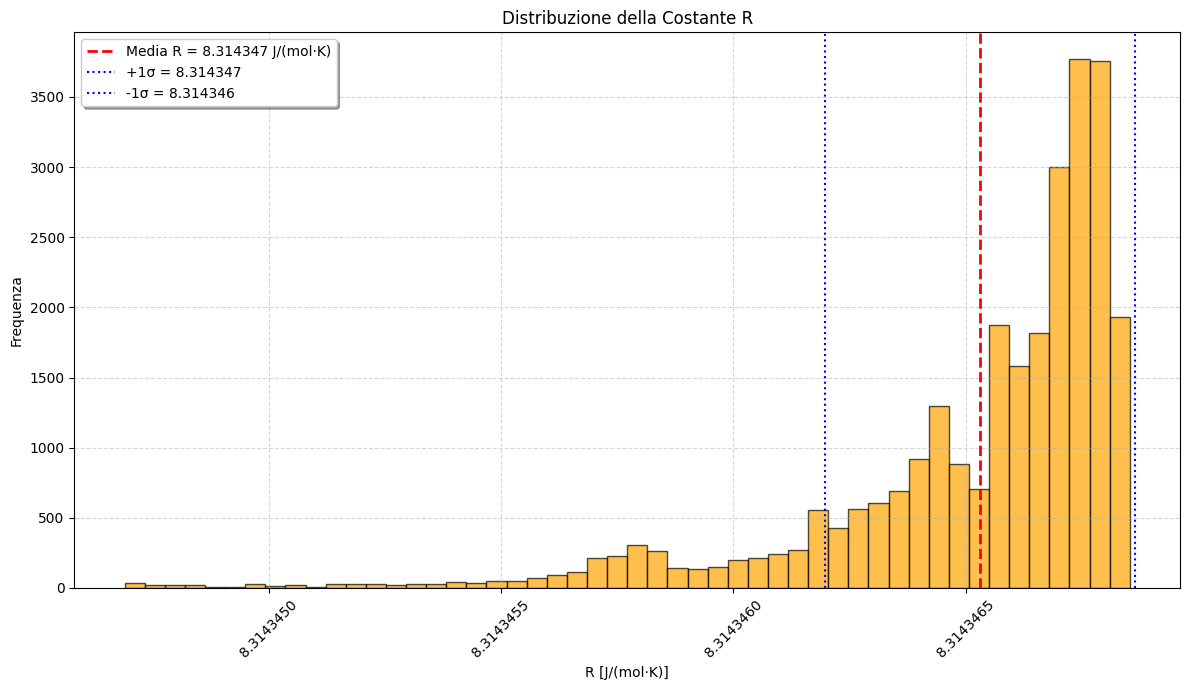

Valore medio calcolato: 8.31434653
Deviazione standard: 3.33040736e-07


In [62]:
# Assicuriamoci che siano nelle stesse unità di misura usate nel calcolo di R
sigma_P_pa = u_P_kpa * 1000.0
sigma_V_m3 = u_V_ml * 1e-6
sigma_T_k  = u_T_c 
sigma_n    = df_risultati['Err_Moli']

P = df['Pressione'] * 1000.0
V = volume_ml * 1e-6
n = df_risultati['Moli']
T = (df['Temperatura'] + 273.15)

# R calcolato
R = (P * V) / (n * T)

# 3. Calcolo dell'errore associato ad ogni istanza di R (Propagazione)
# Usiamo la formula delle derivate prime (quadratica per variabili indipendenti)
err_R = R * np.sqrt(
    (sigma_P_pa / P)**2 +
    (sigma_V_m3 / V)**2 +
    (sigma_n / n)**2 +
    (sigma_T_k / T)**2
)

# 4. Aggiornamento DataFrame
df_R = pd.DataFrame({
    'R': R,
    'Err_R': err_R
})

# 3. Statistiche
mean_R = df_R['R'].mean()
std_R = df_R['R'].std()

# 4. Plotting
plt.figure(figsize=(12, 7))
plt.hist(df_R['R'], bins=50, color='orange', edgecolor='black', alpha=0.7)

# Linee statistiche con alta precisione nei label
plt.axvline(mean_R, color='red', linestyle='dashed', linewidth=2, 
            label=f'Media R = {mean_R:.6f} J/(mol·K)')
plt.axvline(mean_R + std_R, color='blue', linestyle='dotted', linewidth=1.5, 
            label=f'+1σ = {mean_R + std_R:.6f}')
plt.axvline(mean_R - std_R, color='blue', linestyle='dotted', linewidth=1.5, 
            label=f'-1σ = {mean_R - std_R:.6f}')

# --- FIX ASSE X (Rimuove l'offset 1e-7 + 8.314...) ---
ax = plt.gca()

import matplotlib.ticker as ticker

# Forza la visualizzazione dei valori assoluti senza offset
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# Specifica il numero di decimali da mostrare per apprezzare la dispersione
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.7f'))

plt.title('Distribuzione della Costante R')
plt.xlabel('R [J/(mol·K)]')
plt.ylabel('Frequenza')
plt.xticks(rotation=45) # Ruota per evitare sovrapposizioni date dall'alta precisione
plt.legend(loc='best', frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Valore medio calcolato: {mean_R:.8f}")
print(f"Deviazione standard: {std_R:.8e}")


In [63]:
#media pesata degli R
weights = 1 / (df_R['Err_R'] ** 2)
weighted_mean_R = np.sum(df_R['R'] * weights) / np.sum(weights)
weighted_std_R = np.sqrt(1 / np.sum(weights))   
print(f"Media pesata di R: {weighted_mean_R:.8f} ± {weighted_std_R:.8e} J/(mol·K)")

Media pesata di R: 8.31434653 ± 3.37218833e-04 J/(mol·K)


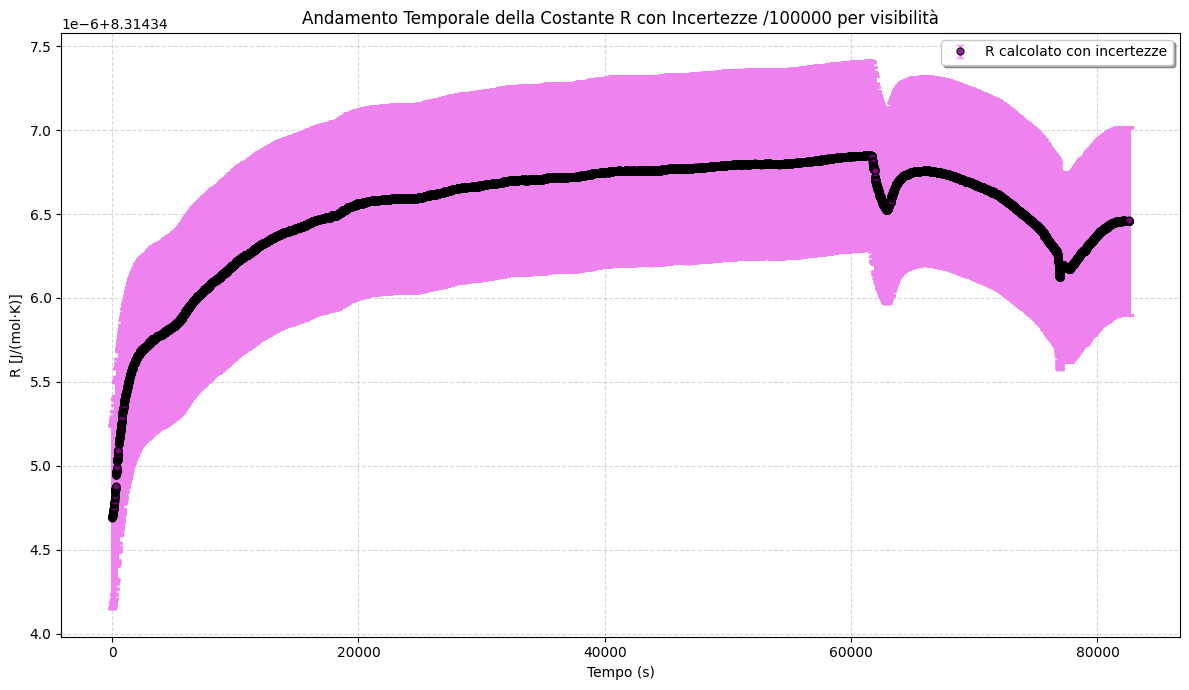

In [64]:
#plot di R con barre d'errore nel tempo
plt.figure(figsize=(12, 7))
plt.errorbar(df_R.index * 3, df_R['R'], 
             yerr=df_R['Err_R']/100000, 
             fmt='o', markersize=5, markerfacecolor='purple', markeredgecolor='black',
             ecolor='violet', elinewidth=2, capsize=3, alpha=0.8,
             label='R calcolato con incertezze')
plt.title(r'Andamento Temporale della Costante R con Incertezze /100000 per visibilità')
plt.xlabel('Tempo (s)')
plt.ylabel('R [J/(mol·K)]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()  

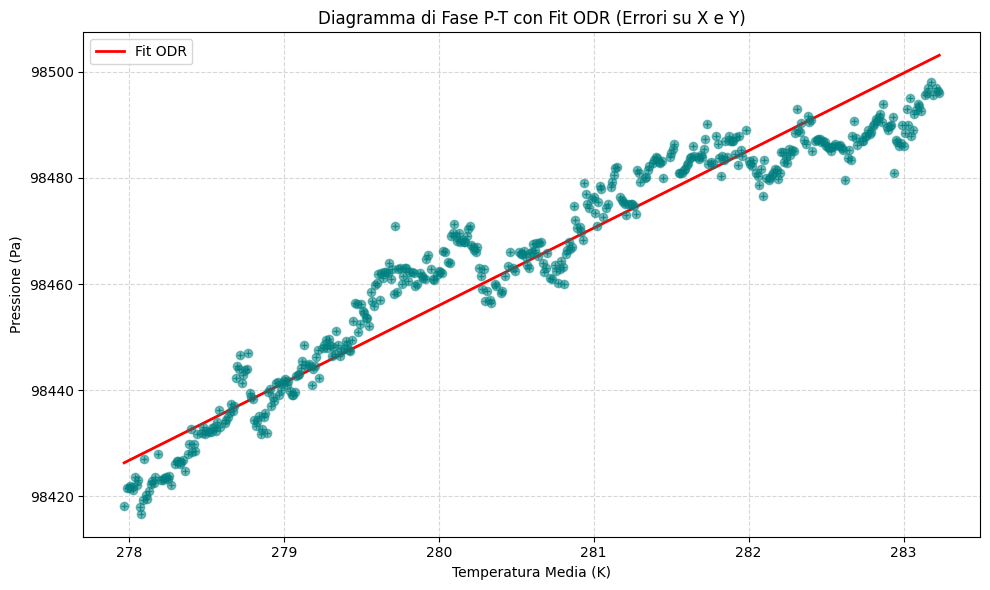

------------------------------
PARAMETRI FIT ODR (y = mx + q)
------------------------------
Pendenza (m)   : 14.6171 ± 0.1938 Pa/K
Intercetta Y (q): 94363.1465 ± 54.3838 Pa
------------------------------
Temperatura allo zero di Pressione:
T(P=0) = -6455.66 ± 212.96 K
------------------------------
------------------------------
VERIFICA COMPATIBILITÀ ZERO ASSOLUTO in K
------------------------------
Compatibilità in termini di σ: 30.31 σ


In [67]:
from scipy import odr

# 1. Preparazione Dati
# Seleziono il range temporale richiesto
df_filtered = df[(df['Tempo_Simulato_s'] >= 6600) & (df['Tempo_Simulato_s'] <= 20000)].copy()

# Raggruppo per Temperatura e medio la Pressione
# Nota: Groupby Temperatura riduce il rumore sulla variabile dipendente P
df_PT = df_filtered[['Pressione', 'Temperatura']].groupby('Temperatura').mean().reset_index()

# Definisco x (Temp) e y (Press)
x = df_PT['Temperatura'].values + 273.15  # converto in Kelvin per il fit
y = df_PT['Pressione'].values * 1000.0    # kPa -> Pa

# 2. Configurazione ODR (Orthogonal Distance Regression)
# Definisco il modello lineare: y = m*x + q (B[0]=slope, B[1]=intercept)
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])

# Creo l'oggetto RealData con le incertezze costanti (sx=1, sy=0.1)
my_data = odr.RealData(x, y, sx=1.0, sy=0.1)

#inizializo
my_odr = odr.ODR(my_data, linear_model, beta0=[0.1, 90])

# Eseguo il fit
output = my_odr.run()

# Estraggo parametri e incertezze (Deviazione Standard)
m, q = output.beta          # m=pendenza, q=intercetta Y
sm, sq = output.sd_beta     # incertezze su m e q
cov = output.cov_beta       # matrice di covarianza (necessaria per prop. errore)

# 3. Calcolo Temperatura a Pressione 0 (Intercetta asse X)
T0 = -q / m

# Propagazione dell'errore per T0 
deriv_q = -1 / m
deriv_m = q / (m**2)

var_T0 = (deriv_q**2 * output.cov_beta[1, 1] + 
          deriv_m**2 * output.cov_beta[0, 0] + 
          2 * deriv_q * deriv_m * output.cov_beta[0, 1])

sT0 = np.sqrt(var_T0)

# 4. Plotting 
plt.figure(figsize=(10, 6))

# Dati con barre d'errore
# plotto con errori nulli per evidenziare i punti senza barre d'errore
plt.errorbar(x, y, xerr=0, yerr=0, fmt='o', 
             color='teal', ecolor='teal', alpha=0.5, capsize=2)

# Retta di fit
x_fit = np.linspace(min(x), max(x), 100)
y_fit = m * x_fit + q
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Fit ODR')

plt.title('Diagramma di Fase P-T con Fit ODR (Errori su X e Y)')
plt.ylabel('Pressione (Pa)')
plt.xlabel('Temperatura Media (K)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 5. Risultati
print("-" * 30)
print("PARAMETRI FIT ODR (y = mx + q)")
print("-" * 30)
print(f"Pendenza (m)   : {m:.4f} ± {sm:.4f} Pa/K")
print(f"Intercetta Y (q): {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)
print(f"Temperatura allo zero di Pressione:")
print(f"T(P=0) = {T0:.2f} ± {sT0:.2f} K")
print("-" * 30)

# 6. compatibilità con zero assoluto 
print("-" * 30)
print("VERIFICA COMPATIBILITÀ ZERO ASSOLUTO in K")
print("-" * 30)
zero_assoluto_c = 0
diff_T0_zero_assoluto = abs(T0 - zero_assoluto_c)
comp = diff_T0_zero_assoluto / sT0
print(f"Compatibilità in termini di σ: {comp:.2f} σ")    
